# Maximal Representative Subsampling

In [1]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
np.seterr(divide = 'ignore') 

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from scipy import stats

%run utils.py

path = Path(os.getcwd()).parent


## Attribute Comparison

Each row is labelled with its (survey) *source*.

- *Source*
- Geschlecht
- Geburtsjahr
- Hoechster Bildungsabschluss
- Erwerbstaetigkeit
- Soziale Unterstuetzung

### Preprocessing: Allensbach

In [2]:
allensbach_cols = ['S01', 'S02', 'S03_rec', 'S05', 'V19']
allensbach_names = ['Geschlecht', 'Geburtsjahr', 'Hoechster Bildungsabschluss', 'Erwerbstaetigkeit',
                    'Soziale Unterstuetzung']

allensbach = pd.read_csv(os.path.join(path, 'data/Allensbach/abs_data.csv'),
                         usecols = allensbach_cols,
                         delimiter=';', low_memory=False)

allensbach.replace(',', '.', regex=True, inplace=True)
allensbach.replace(' ', np.nan, regex=True, inplace=True)

allensbach = allensbach.fillna(allensbach.median()) # quick fix, for the time being.
allensbach.rename(columns= dict(zip(allensbach_cols, allensbach_names)), inplace=True)

allensbach.head()

Geschlecht Geburtsjahr Erwerbstaetigkeit Soziale Unterstuetzung  \
0           2          73                 2                      3   
1           2          24                 1                      2   
2           1          51                 1                      4   
3           1          57                 1                      2   
4           1          64                 2                      4   

  Hoechster Bildungsabschluss  
0                           2  
1                           3  
2                           3  
3                           5  
4                           2

### Preprocessing: GBS

In [3]:
gbs1 = pd.read_csv(os.path.join(path, 'data/GBS/gbs1.csv'))
gbs2 = pd.read_csv(os.path.join(path, 'data/GBS/gbs2.csv'))

mapping1 = pd.read_csv(os.path.join(path, 'data/GBS/gbs_map1.csv'),
                                    encoding = "ISO-8859-1", delimiter = ';')
mapping2 = pd.read_csv(os.path.join(path, 'data/GBS/gbs_map2.csv'),
                                    encoding = "ISO-8859-1", delimiter = ';')

# Rename 'GBS-CODE' column
key = 'GBS-CODE'
mapping1 = mapping1.rename(columns={'GBS Code': key})
mapping2 = mapping2.rename(columns={'GBS Code': key})
gbs1 = gbs1.rename(columns={'gbs_code': key})
gbs2 = gbs2.rename(columns={'GBS-Code': key})

# Merge GBS "Umfrage Wellen" and create dataframe
gbs = pd.merge(gbs1, gbs2, how='inner', on=key)
gbs = pd.merge(gbs, mapping1, how='left', on=key)
gbs = pd.merge(gbs, mapping2, how='left', on=key)

gbs_cols = ['am01', 'am02_01', 'am14', 'am17', 'os03']
allensbach_names = ['Geschlecht', 'Geburtsjahr', 'Hoechster Bildungsabschluss', 
                    'Erwerbstaetigkeit', 'Soziale Unterstuetzung',]

gbs = gbs[gbs_cols]
gbs.rename(columns= dict(zip(gbs_cols, allensbach_names)), inplace=True)


del mapping1, mapping2, gbs1, gbs2

# TODO: Combine matching rows instead of selecting every 2nd.
gbs = gbs.iloc[::2, :]


di1 = {'männlich': 1, "Männlich": 1, 'weiblich': 2, "Weiblich": 2, '[NA] Keine Angabe':np.nan}
gbs.replace({"Geschlecht": di1}, inplace=True)

gbs['Geburtsjahr'] = [2017-(int)(gj[:4]) if gj is not np.nan else np.nan for gj in gbs.Geburtsjahr]

di2 = {'Hochschulabschluss':5, 
       'Abitur, allgemeine oder fachgebundene Hochschulreife (Gymnasium bzw. EOS)': 4, 
       'Fachhochschulreife (Abschluss einer Fachoberschule)': 4, 
       'Realschulabschluss (Mittlere Reife)': 3,
       'Hauptschulabschluss/Volksschulabschluss': 2,
       'Abschluss Polytechnische Oberschule 10. Klasse (vor 1965: 8. Klasse)': 1, 
       'Anderer Schulabschluss:': 1}

gbs.replace({'Hoechster Bildungsabschluss': di2}, inplace=True)

di3 = {9:2,
       999:2,
      -3:2,
      -1:2,
      3:2}

# Note: this is also allensbach replacement using same dict
allensbach = allensbach.replace({'Erwerbstaetigkeit': di3})
allensbach['Erwerbstaetigkeit'] = [int(i) for i in allensbach.Erwerbstaetigkeit]

di4 = {'sehr viel Anteilnahme und Interesse':5, 
       'viel Anteilnahme und Interesse': 4, 
       'weder viel noch wenig': 3, 
       'wenig Anteilnahme und Interesse': 2, 
       'keine Anteilnahme und Interesse': 1,
       'keine Angabe':3}
gbs.replace({'Soziale Unterstuetzung': di4}, inplace=True)

gbs.head(5)

Geschlecht  Geburtsjahr  Hoechster Bildungsabschluss  Erwerbstaetigkeit  \
0         1.0         38.0                          4.0                1.0   
2         2.0         72.0                          5.0                1.0   
4         1.0         68.0                          5.0                1.0   
6         2.0         25.0                          5.0                1.0   
8         2.0         33.0                          2.0                1.0   

   Soziale Unterstuetzung  
0                     4.0  
2                     3.0  
4                     4.0  
6                     4.0  
8                     4.0

### Preprocessing: GESIS

We might need this later.

In [4]:
gesis1 = pd.read_csv(os.path.join(path, 'data/GESIS/ZA5665_a1_a11-a12_v22-0-0.dta.csv'), 
                     engine='python', encoding = "ISO-8859-1")
gesis2 = pd.read_csv(os.path.join(path, 'data/GESIS/ZA5665_a1_ca-cf_v22-0-0.dta.csv'), 
                     engine='python', encoding = "ISO-8859-1")
gesis3 = pd.read_csv(os.path.join(path, 'data/GESIS/ZA5665_a1_ba-bf_v22-0-0.dta.csv'), 
                     engine='python', encoding = "ISO-8859-1")
gesis4 = pd.read_csv(os.path.join(path, 'data/GESIS/ZA5665_a1_aa-ac_v22-0-0 (1).dta.csv'), 
                     engine='python', encoding = "ISO-8859-1")

gesis5 = pd.merge(gesis1, gesis2, how='inner', on='z000001a')
gesis6 = pd.merge(gesis3, gesis4, how='inner', on='z000001a')
gesis  = pd.merge(gesis5, gesis6, how='inner', on='z000001a')

del gesis1,gesis2,gesis3,gesis4,gesis5,gesis6

gesis = gesis[['a11d054a', 'a11d056b', 'a11d082b', 'a11d089c', 
              'a11d092a', 'acae051a', 'acae058a', 'acae062a', 
              'acae079a', 'acae089a', 'acae099a', 'acae085a', 
              'acae095a', 'acae105a', 'bdao099a']]
gesis.head(5)

a11d054a a11d056b                                           a11d082b  \
0  Männlich     1946                 Fachhochschulreife, Fachoberschule   
1  Weiblich     1974                                Hauptschulabschluss   
2  Weiblich     1994                                        Schüler/-in   
3  Männlich     1950  Abitur, allgemeine oder fachgebundene Hochschu...   
4  Männlich     1990                                 Realschulabschluss   

               a11d089c           a11d092a    acae051a           acae058a  \
0    Nicht erwerbstätig  Missing by filter   Stimme zu         Weder noch   
1  Vollzeiterwerbstätig     Angestellte(r)  Weder noch          Stimme zu   
2    Nicht erwerbstätig  Missing by filter   Stimme zu     Lehne stark ab   
3  Vollzeiterwerbstätig     Angestellte(r)   Stimme zu    Stimme stark zu   
4  Vollzeiterwerbstätig     Angestellte(r)   Stimme zu  Missing by design   

            acae062a           acae079a           acae089a           acae099a  \
0  Missing by design                  8  Missing by design  Missing by design   
1  Missing by design  Missing by design                  5  Missing by design   
2  Missing by design                  9  Missing by design  Missing by design   
3  Missing by design  Missing by design  Missing by design   Item nonresponse   
4           Lehne ab                  8  Missing by design  Missing by design   

            acae085a           acae095a           acae105a  \
0                  6  Missing by design  Missing by design   
1  Missing by design                  3  Missing by design   
2                  6  Missing by design  Missing by design   
3  Missing by design  Missing by design                  6   
4                  5  Missing by design  Missing by design   

                  bdao099a  
0            Mittelschicht  
1           Weiß ich nicht  
2         Unit nonresponse  
3  Keiner dieser Schichten  
4              Not reached

- "['a12d021a' 'a12d024a' 'dezg083a'] not in index"

## Experiment

In [19]:
allensbach['label'] = 'rep'
gbs['label'] = 'nonrep'

rep = allensbach.copy(deep=True)
non_rep = gbs.copy(deep=True)

data = pd.concat([rep, non_rep], sort=True).copy(deep=True)

data = data.fillna(data.median()) # quick fix, for the time being.
data.reset_index(drop=True, inplace=True)

data['probs'] = len(data.label)*[0]

data.head()

Erwerbstaetigkeit Geburtsjahr  Geschlecht Hoechster Bildungsabschluss  \
0                2.0          73         2.0                           2   
1                1.0          24         2.0                           3   
2                1.0          51         1.0                           3   
3                1.0          57         1.0                           5   
4                2.0          64         1.0                           2   

  Soziale Unterstuetzung label  probs  
0                      3   rep      0  
1                      2   rep      0  
2                      4   rep      0  
3                      2   rep      0  
4                      4   rep      0

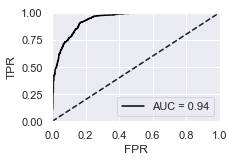

length of current GBS subset: 503


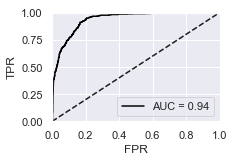

length of current GBS subset: 502


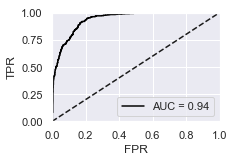

length of current GBS subset: 501


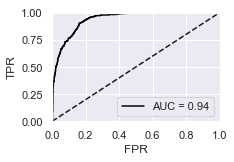

length of current GBS subset: 500


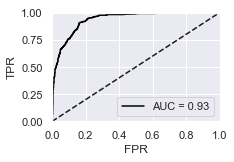

length of current GBS subset: 499


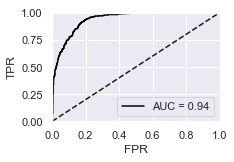

length of current GBS subset: 498


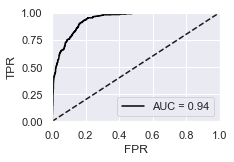

length of current GBS subset: 497


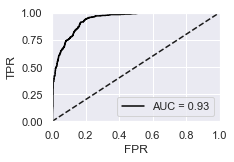

length of current GBS subset: 496


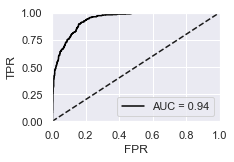

length of current GBS subset: 495


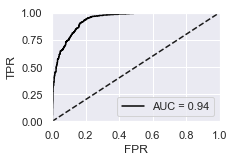

length of current GBS subset: 494


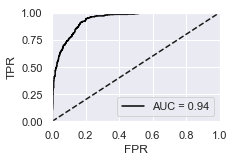

length of current GBS subset: 493


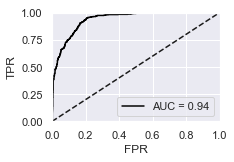

length of current GBS subset: 492


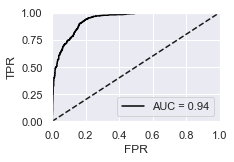

length of current GBS subset: 491


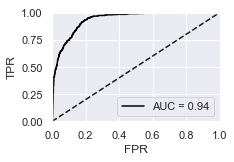

length of current GBS subset: 490


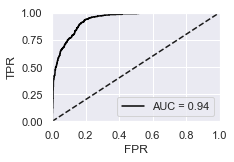

length of current GBS subset: 489


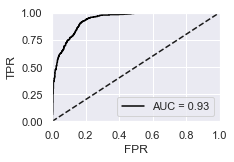

length of current GBS subset: 488


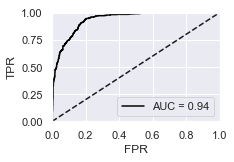

length of current GBS subset: 487


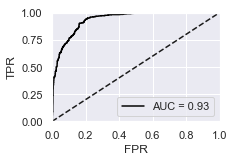

length of current GBS subset: 486


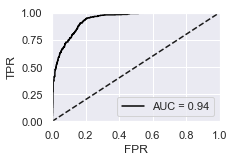

length of current GBS subset: 485


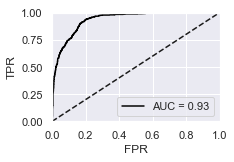

length of current GBS subset: 484


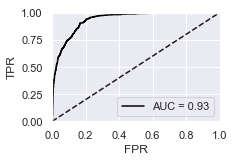

length of current GBS subset: 483


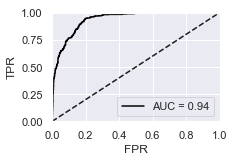

length of current GBS subset: 482


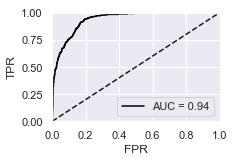

length of current GBS subset: 481


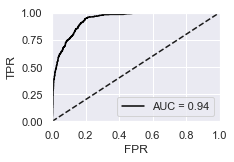

length of current GBS subset: 480


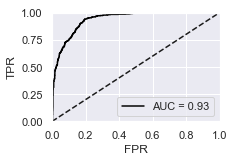

length of current GBS subset: 479


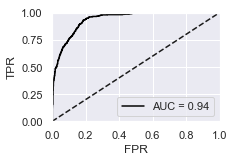

length of current GBS subset: 478


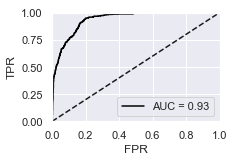

length of current GBS subset: 477


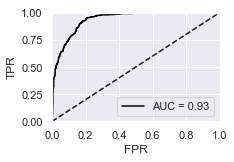

length of current GBS subset: 476


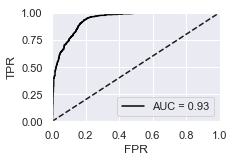

length of current GBS subset: 475


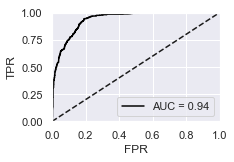

length of current GBS subset: 474


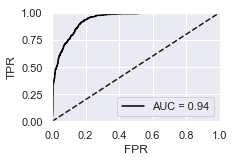

length of current GBS subset: 473


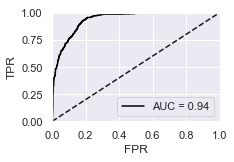

length of current GBS subset: 472


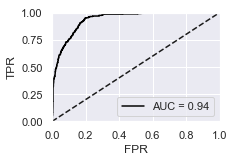

length of current GBS subset: 471


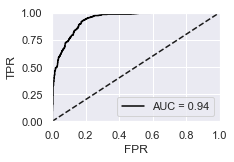

length of current GBS subset: 470


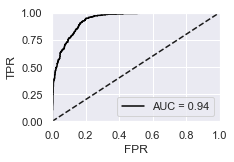

length of current GBS subset: 469


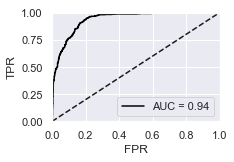

length of current GBS subset: 468


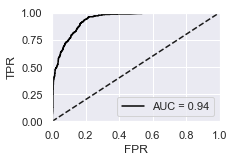

length of current GBS subset: 467


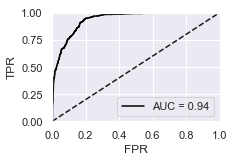

length of current GBS subset: 466


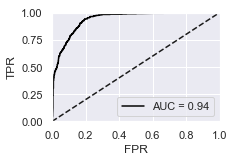

length of current GBS subset: 465


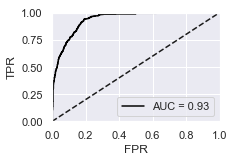

length of current GBS subset: 464


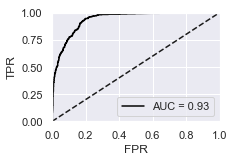

length of current GBS subset: 463


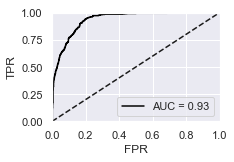

length of current GBS subset: 462


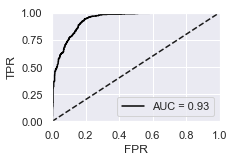

length of current GBS subset: 461


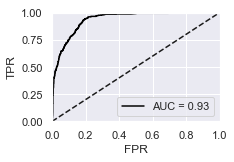

length of current GBS subset: 460


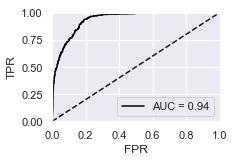

length of current GBS subset: 459


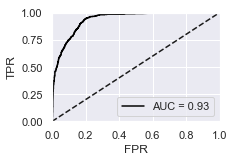

length of current GBS subset: 458


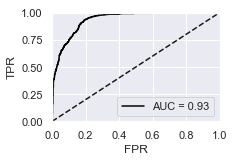

length of current GBS subset: 457


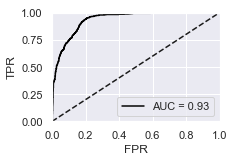

length of current GBS subset: 456


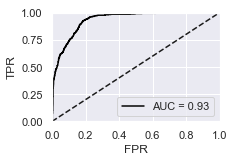

length of current GBS subset: 455


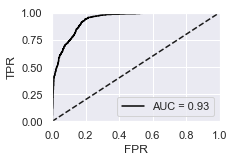

length of current GBS subset: 454


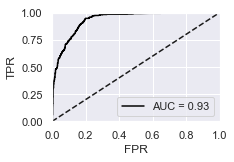

length of current GBS subset: 453


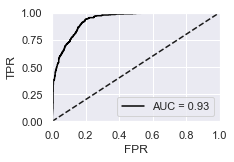

length of current GBS subset: 452


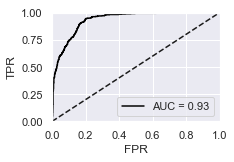

length of current GBS subset: 451


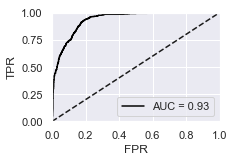

length of current GBS subset: 450


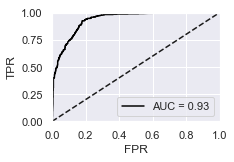

length of current GBS subset: 449


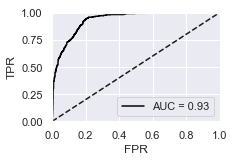

length of current GBS subset: 448


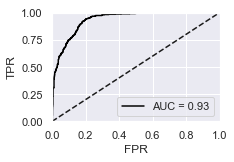

length of current GBS subset: 447


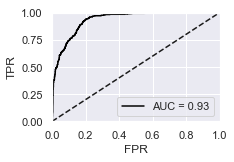

length of current GBS subset: 446


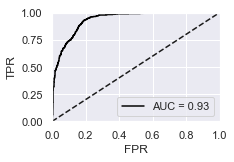

length of current GBS subset: 445


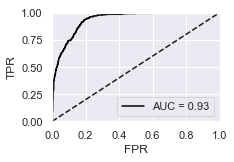

length of current GBS subset: 444


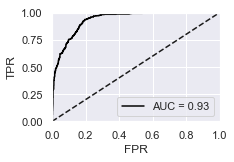

length of current GBS subset: 443


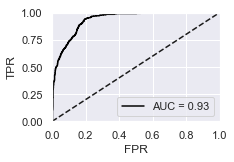

length of current GBS subset: 442


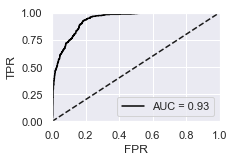

length of current GBS subset: 441


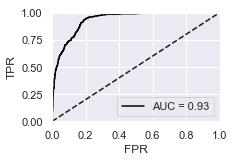

length of current GBS subset: 440


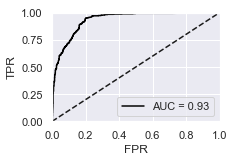

length of current GBS subset: 439


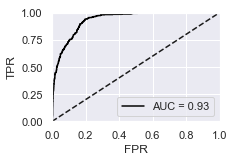

length of current GBS subset: 438


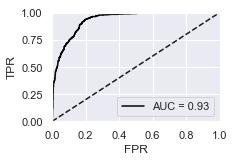

length of current GBS subset: 437


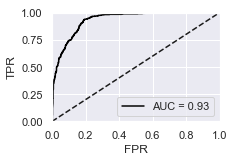

length of current GBS subset: 436


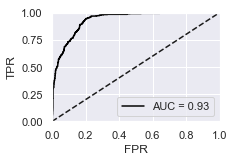

length of current GBS subset: 435


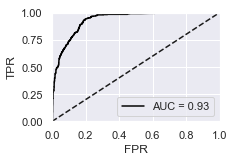

length of current GBS subset: 434


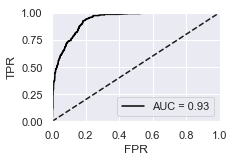

length of current GBS subset: 433


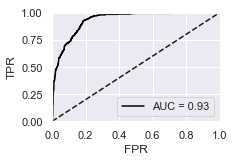

length of current GBS subset: 432


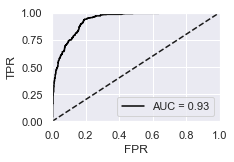

length of current GBS subset: 431


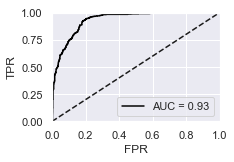

length of current GBS subset: 430


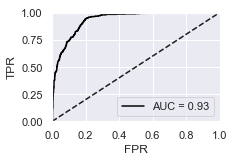

length of current GBS subset: 429


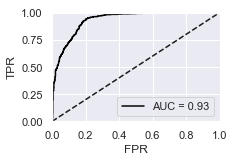

length of current GBS subset: 428


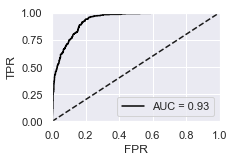

length of current GBS subset: 427


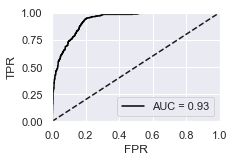

length of current GBS subset: 426


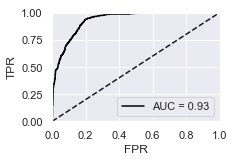

length of current GBS subset: 425


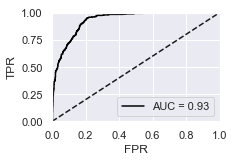

length of current GBS subset: 424


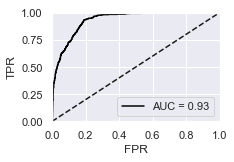

length of current GBS subset: 423


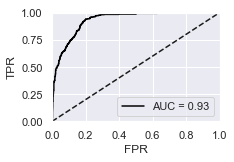

length of current GBS subset: 422


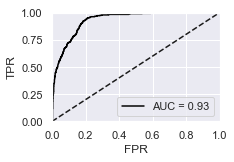

length of current GBS subset: 421


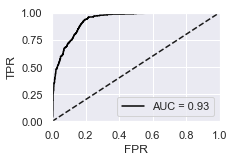

length of current GBS subset: 420


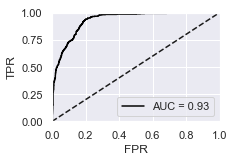

length of current GBS subset: 419


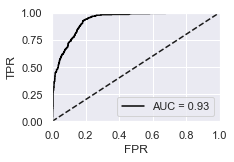

length of current GBS subset: 418


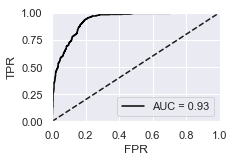

length of current GBS subset: 417


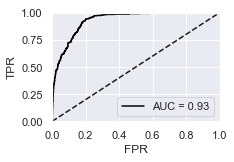

length of current GBS subset: 416


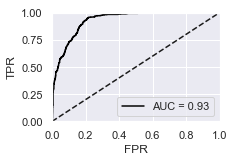

length of current GBS subset: 415


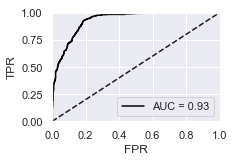

length of current GBS subset: 414


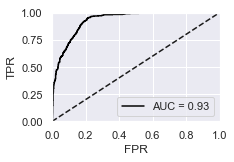

length of current GBS subset: 413


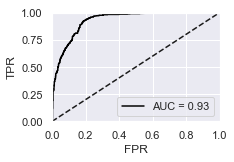

length of current GBS subset: 412


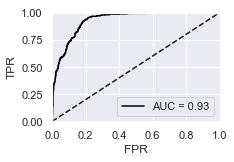

length of current GBS subset: 411


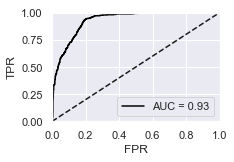

length of current GBS subset: 410


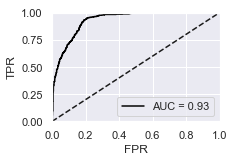

length of current GBS subset: 409


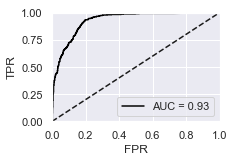

length of current GBS subset: 408


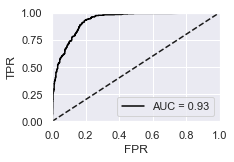

length of current GBS subset: 407


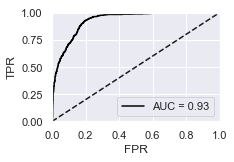

length of current GBS subset: 406


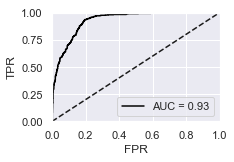

length of current GBS subset: 405


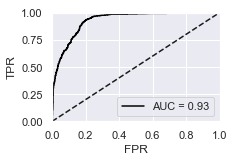

length of current GBS subset: 404


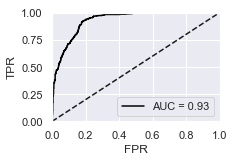

length of current GBS subset: 403


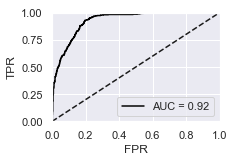

length of current GBS subset: 402


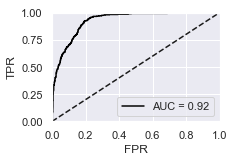

length of current GBS subset: 401


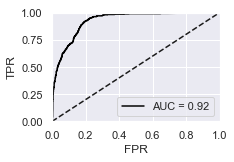

length of current GBS subset: 400


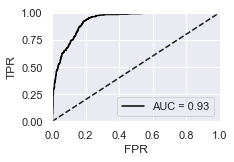

length of current GBS subset: 399


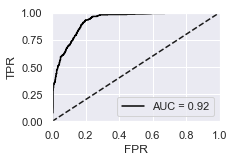

length of current GBS subset: 398


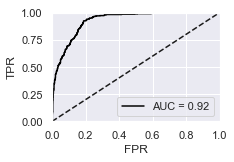

length of current GBS subset: 397


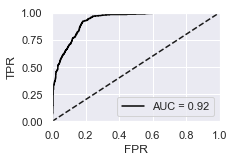

length of current GBS subset: 396


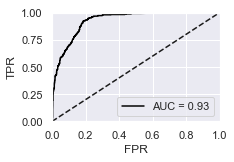

length of current GBS subset: 395


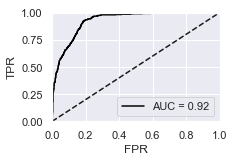

length of current GBS subset: 394


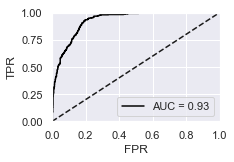

length of current GBS subset: 393


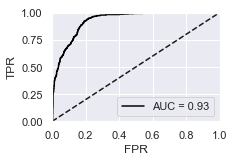

length of current GBS subset: 392


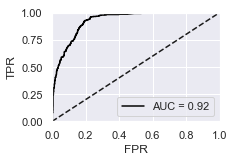

length of current GBS subset: 391


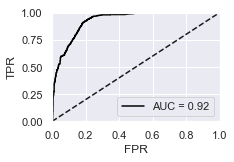

length of current GBS subset: 390


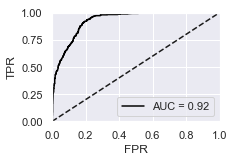

length of current GBS subset: 389


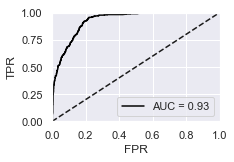

length of current GBS subset: 388


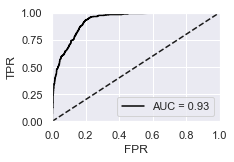

length of current GBS subset: 387


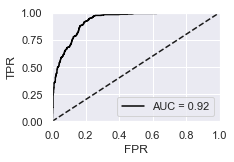

length of current GBS subset: 386


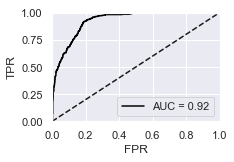

length of current GBS subset: 385


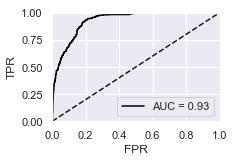

length of current GBS subset: 384


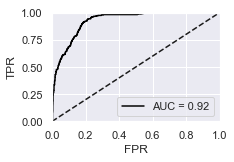

length of current GBS subset: 383


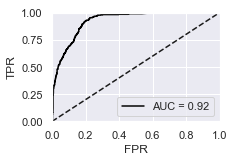

length of current GBS subset: 382


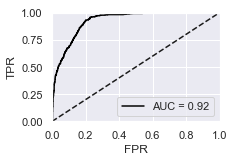

length of current GBS subset: 381


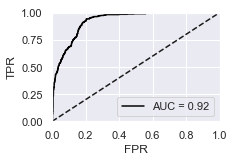

length of current GBS subset: 380


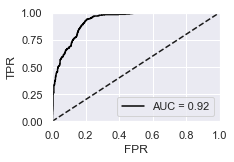

length of current GBS subset: 379


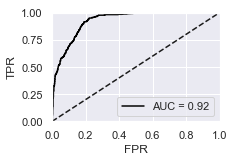

length of current GBS subset: 378


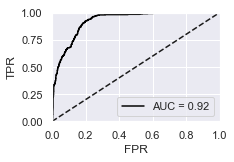

length of current GBS subset: 377


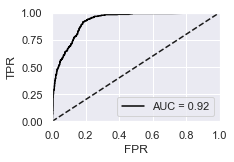

length of current GBS subset: 376


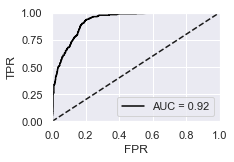

length of current GBS subset: 375


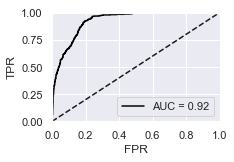

length of current GBS subset: 374


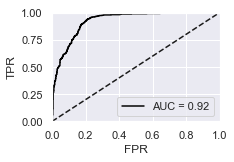

length of current GBS subset: 373


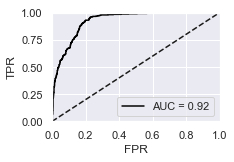

length of current GBS subset: 372


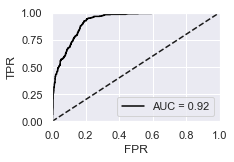

length of current GBS subset: 371


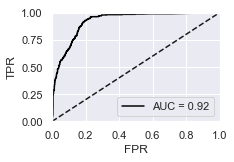

length of current GBS subset: 370


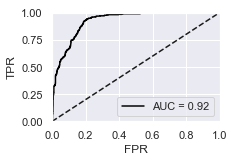

length of current GBS subset: 369


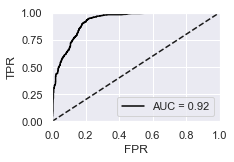

length of current GBS subset: 368


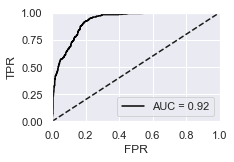

length of current GBS subset: 367


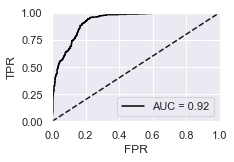

length of current GBS subset: 366


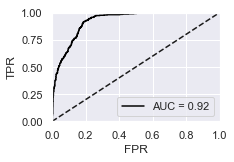

length of current GBS subset: 365


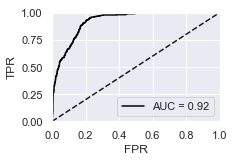

length of current GBS subset: 364


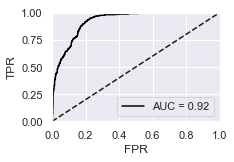

length of current GBS subset: 363


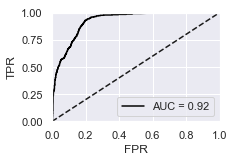

length of current GBS subset: 362


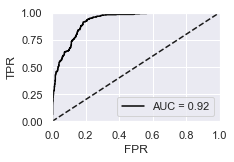

length of current GBS subset: 361


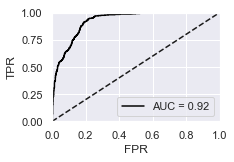

length of current GBS subset: 360


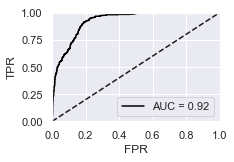

length of current GBS subset: 359


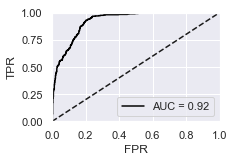

length of current GBS subset: 358


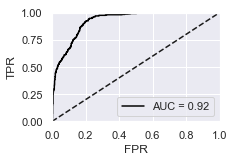

length of current GBS subset: 357


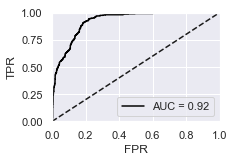

length of current GBS subset: 356


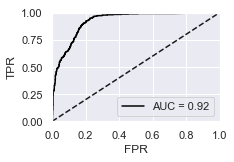

length of current GBS subset: 355


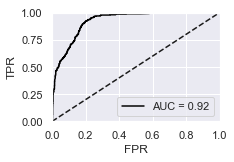

length of current GBS subset: 354


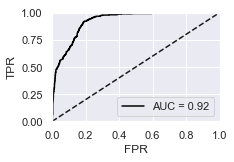

length of current GBS subset: 353


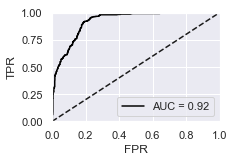

length of current GBS subset: 352


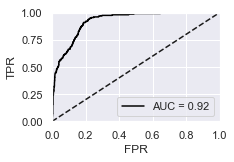

length of current GBS subset: 351


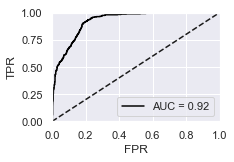

length of current GBS subset: 350


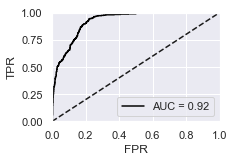

length of current GBS subset: 349


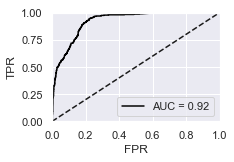

length of current GBS subset: 348


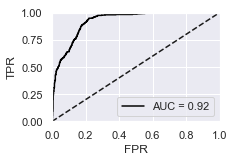

length of current GBS subset: 347


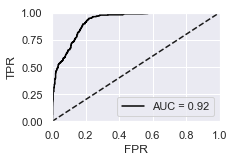

length of current GBS subset: 346


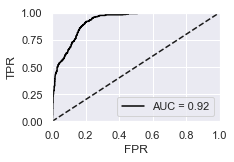

length of current GBS subset: 345


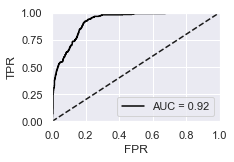

length of current GBS subset: 344


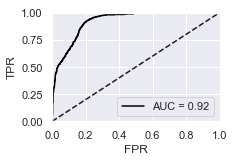

length of current GBS subset: 343


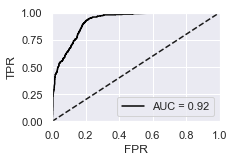

length of current GBS subset: 342


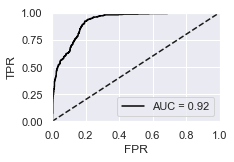

length of current GBS subset: 341


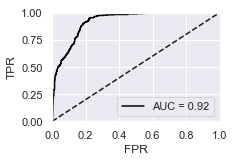

length of current GBS subset: 340


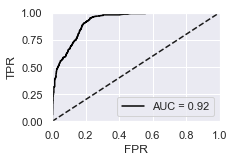

length of current GBS subset: 339


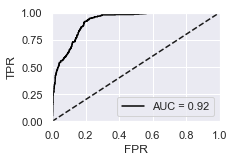

length of current GBS subset: 338


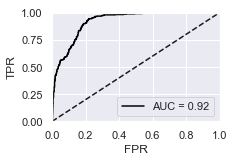

length of current GBS subset: 337


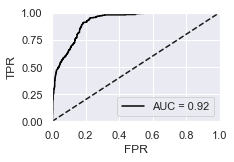

length of current GBS subset: 336


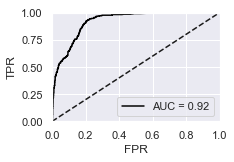

length of current GBS subset: 335


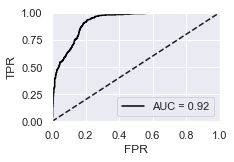

length of current GBS subset: 334


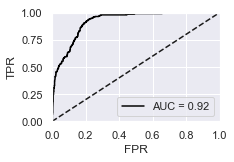

length of current GBS subset: 333


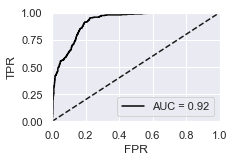

length of current GBS subset: 332


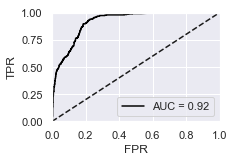

length of current GBS subset: 331


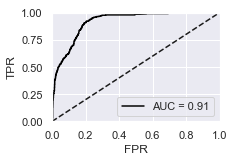

length of current GBS subset: 330


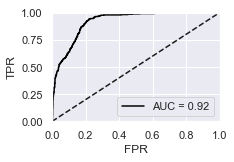

length of current GBS subset: 329


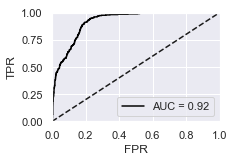

length of current GBS subset: 328


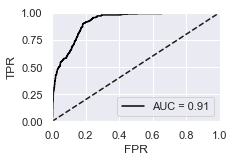

length of current GBS subset: 327


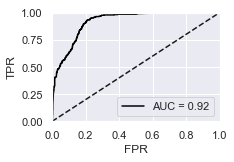

length of current GBS subset: 326


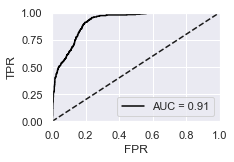

length of current GBS subset: 325


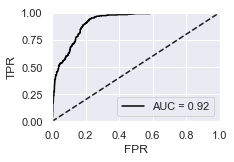

length of current GBS subset: 324


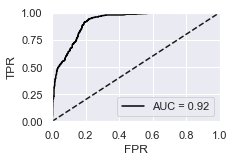

length of current GBS subset: 323


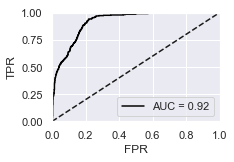

length of current GBS subset: 322


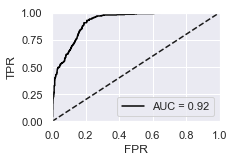

length of current GBS subset: 321


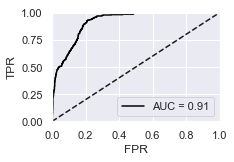

length of current GBS subset: 320


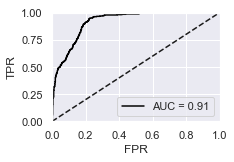

length of current GBS subset: 319


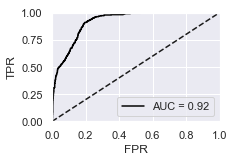

length of current GBS subset: 318


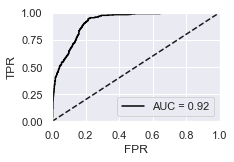

length of current GBS subset: 317


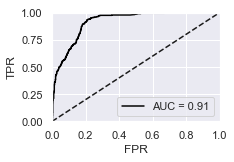

length of current GBS subset: 316


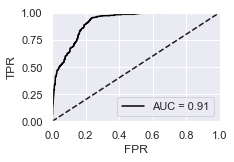

length of current GBS subset: 315


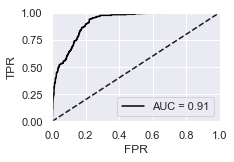

length of current GBS subset: 314


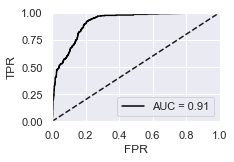

length of current GBS subset: 313


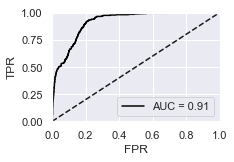

length of current GBS subset: 312


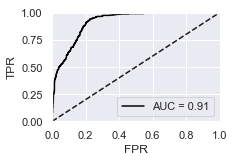

length of current GBS subset: 311


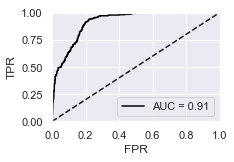

length of current GBS subset: 310


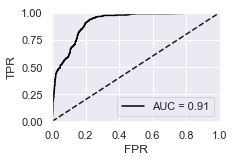

length of current GBS subset: 309


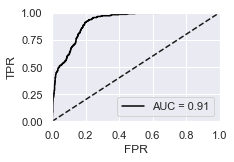

length of current GBS subset: 308


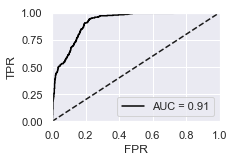

length of current GBS subset: 307


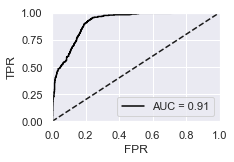

length of current GBS subset: 306


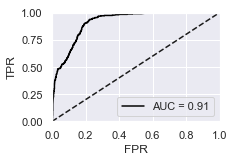

length of current GBS subset: 305


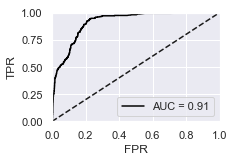

length of current GBS subset: 304


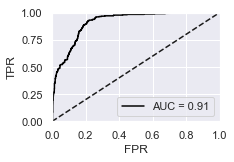

length of current GBS subset: 303


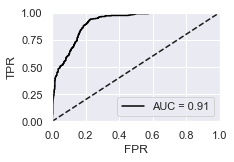

length of current GBS subset: 302


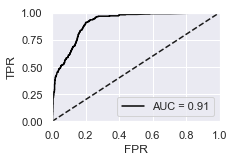

length of current GBS subset: 301


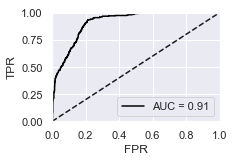

length of current GBS subset: 300


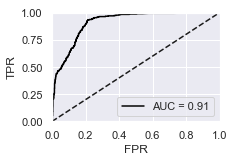

length of current GBS subset: 299


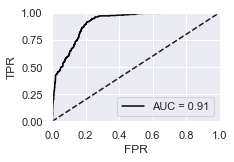

length of current GBS subset: 298


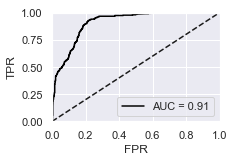

length of current GBS subset: 297


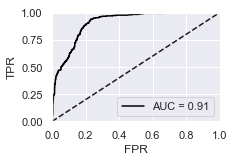

length of current GBS subset: 296


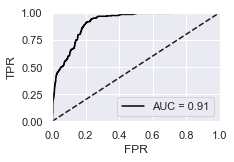

length of current GBS subset: 295


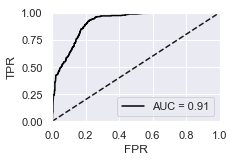

length of current GBS subset: 294


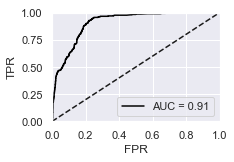

length of current GBS subset: 293


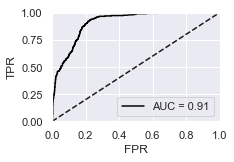

length of current GBS subset: 292


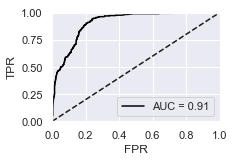

length of current GBS subset: 291


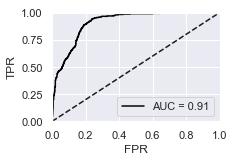

length of current GBS subset: 290


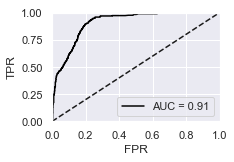

length of current GBS subset: 289


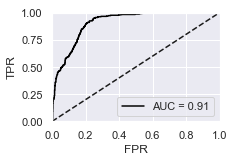

length of current GBS subset: 288


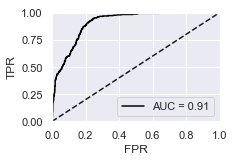

length of current GBS subset: 287


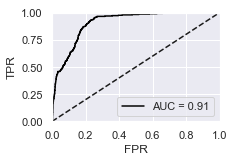

length of current GBS subset: 286


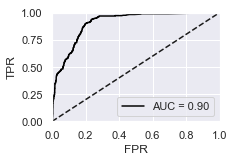

length of current GBS subset: 285


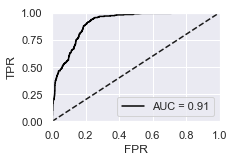

length of current GBS subset: 284


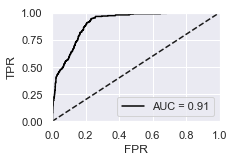

length of current GBS subset: 283


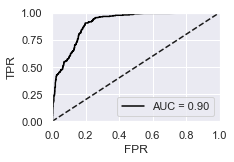

length of current GBS subset: 282


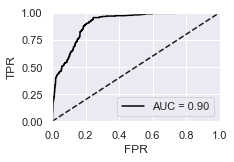

length of current GBS subset: 281


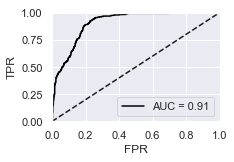

length of current GBS subset: 280


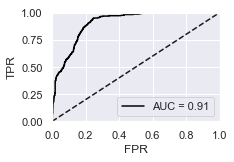

length of current GBS subset: 279


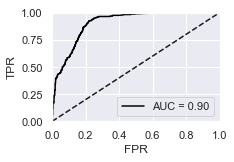

length of current GBS subset: 278


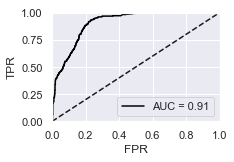

length of current GBS subset: 277


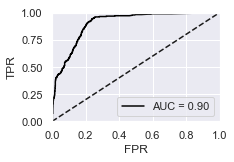

length of current GBS subset: 276


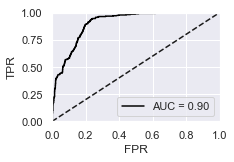

length of current GBS subset: 275


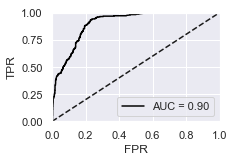

length of current GBS subset: 274


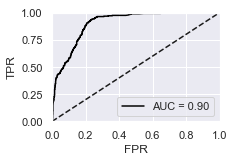

length of current GBS subset: 273


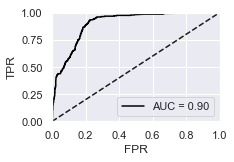

length of current GBS subset: 272


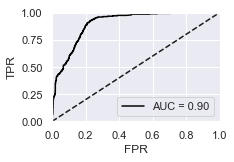

length of current GBS subset: 271


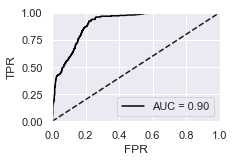

length of current GBS subset: 270


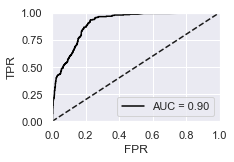

length of current GBS subset: 269


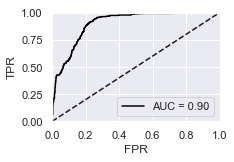

length of current GBS subset: 268


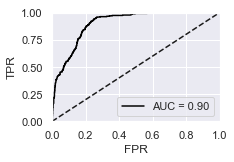

length of current GBS subset: 267


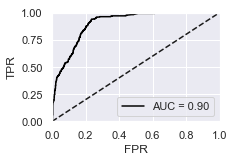

length of current GBS subset: 266


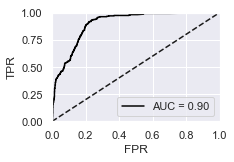

length of current GBS subset: 265


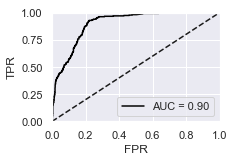

length of current GBS subset: 264


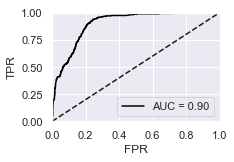

length of current GBS subset: 263


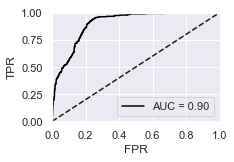

length of current GBS subset: 262


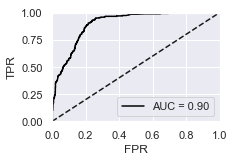

length of current GBS subset: 261


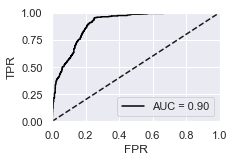

length of current GBS subset: 260


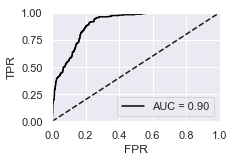

length of current GBS subset: 259


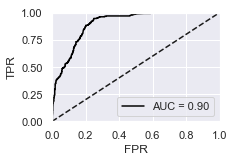

length of current GBS subset: 258


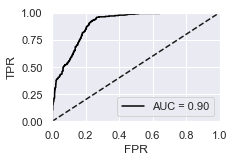

length of current GBS subset: 257


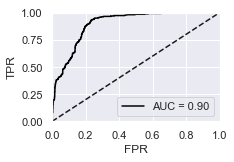

length of current GBS subset: 256


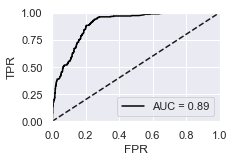

length of current GBS subset: 255


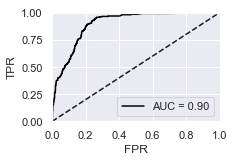

length of current GBS subset: 254


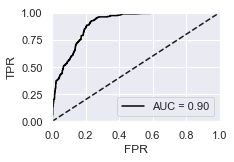

length of current GBS subset: 253


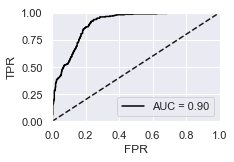

length of current GBS subset: 252


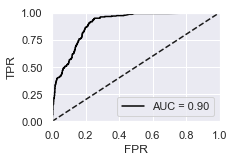

length of current GBS subset: 251


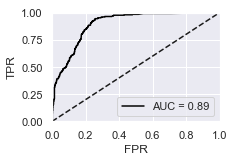

length of current GBS subset: 250


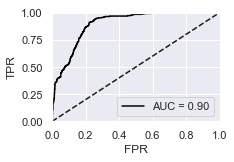

length of current GBS subset: 249


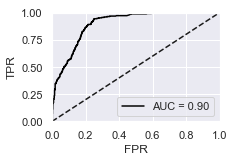

length of current GBS subset: 248


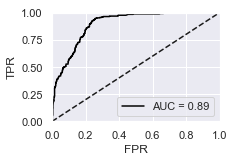

length of current GBS subset: 247


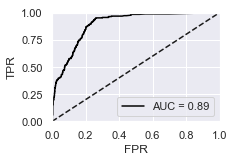

length of current GBS subset: 246


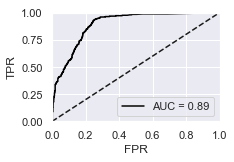

length of current GBS subset: 245


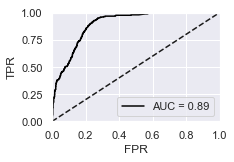

length of current GBS subset: 244


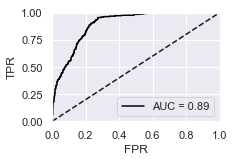

length of current GBS subset: 243


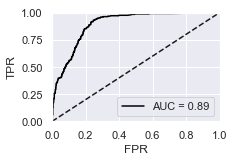

length of current GBS subset: 242


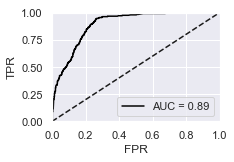

length of current GBS subset: 241


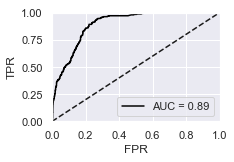

length of current GBS subset: 240


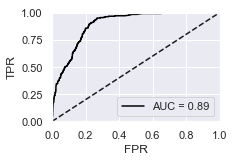

length of current GBS subset: 239


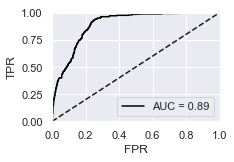

length of current GBS subset: 238


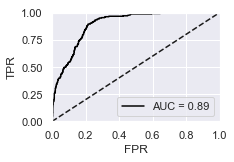

length of current GBS subset: 237


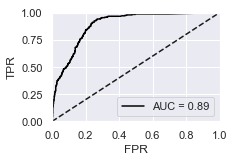

length of current GBS subset: 236


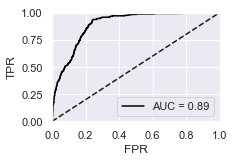

length of current GBS subset: 235


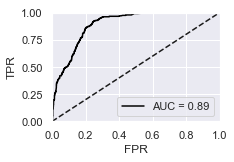

length of current GBS subset: 234


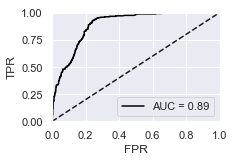

length of current GBS subset: 233


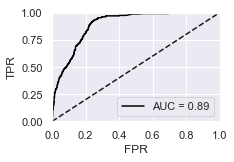

length of current GBS subset: 232


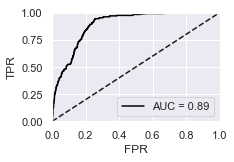

length of current GBS subset: 231


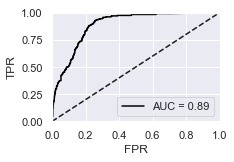

length of current GBS subset: 230


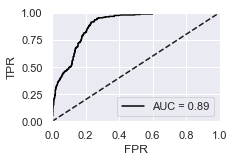

length of current GBS subset: 229


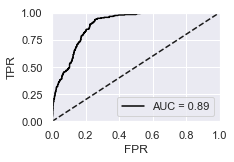

length of current GBS subset: 228


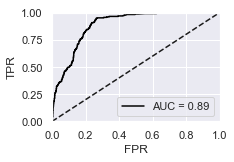

length of current GBS subset: 227


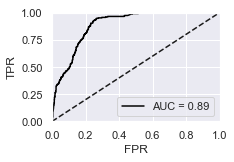

length of current GBS subset: 226


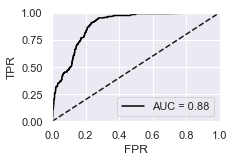

length of current GBS subset: 225


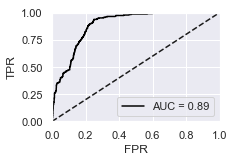

length of current GBS subset: 224


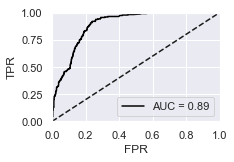

length of current GBS subset: 223


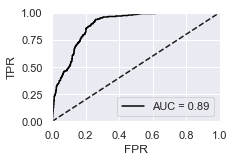

length of current GBS subset: 222


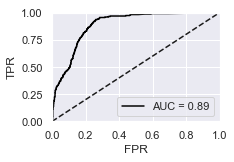

length of current GBS subset: 221


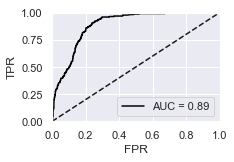

length of current GBS subset: 220


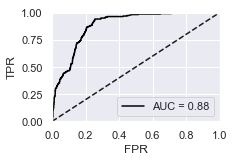

length of current GBS subset: 219


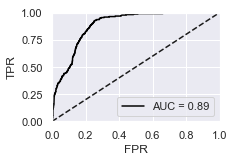

length of current GBS subset: 218


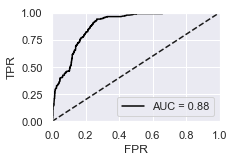

length of current GBS subset: 217


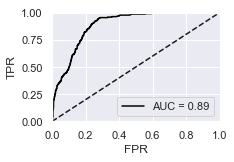

length of current GBS subset: 216


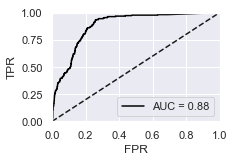

length of current GBS subset: 215


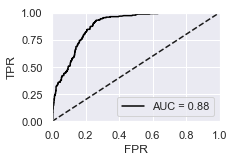

length of current GBS subset: 214


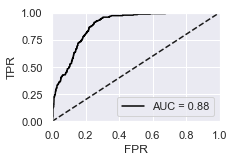

length of current GBS subset: 213


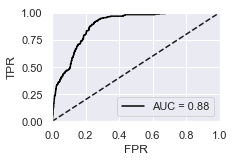

length of current GBS subset: 212


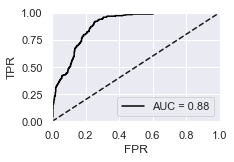

length of current GBS subset: 211


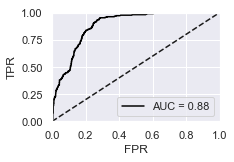

length of current GBS subset: 210


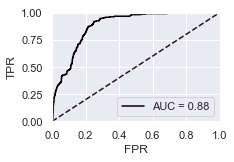

length of current GBS subset: 209


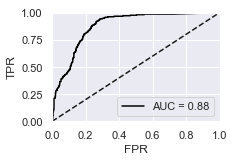

length of current GBS subset: 208


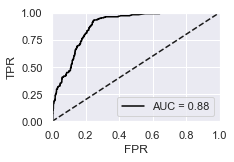

length of current GBS subset: 207


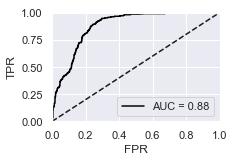

length of current GBS subset: 206


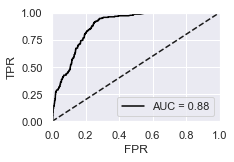

length of current GBS subset: 205


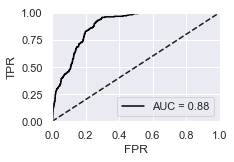

length of current GBS subset: 204


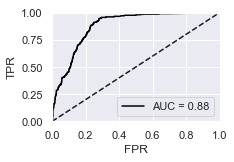

length of current GBS subset: 203


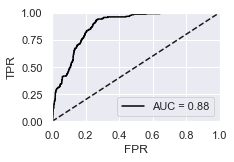

length of current GBS subset: 202


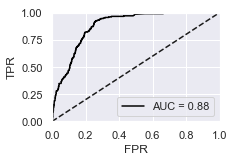

length of current GBS subset: 201


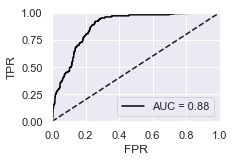

length of current GBS subset: 200


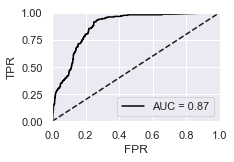

length of current GBS subset: 199


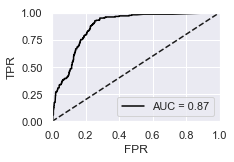

length of current GBS subset: 198


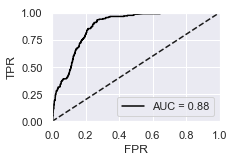

length of current GBS subset: 197


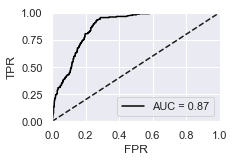

length of current GBS subset: 196


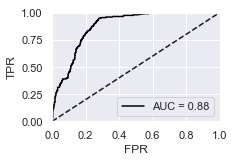

length of current GBS subset: 195


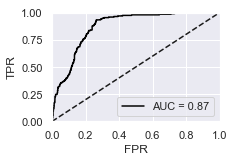

length of current GBS subset: 194


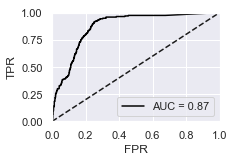

length of current GBS subset: 193


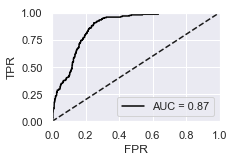

length of current GBS subset: 192


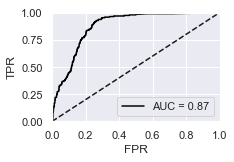

length of current GBS subset: 191


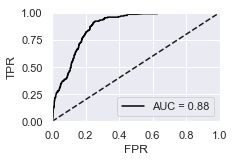

length of current GBS subset: 190


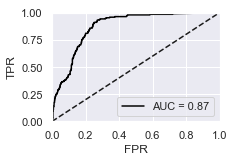

length of current GBS subset: 189


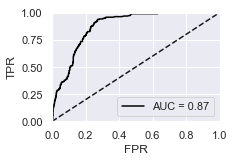

length of current GBS subset: 188


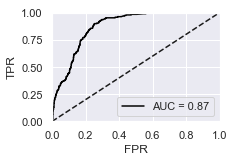

length of current GBS subset: 187


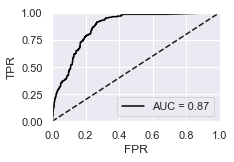

length of current GBS subset: 186


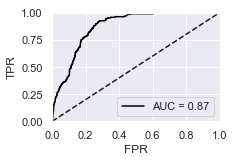

length of current GBS subset: 185


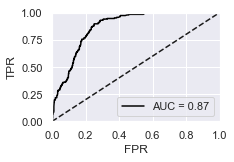

length of current GBS subset: 184


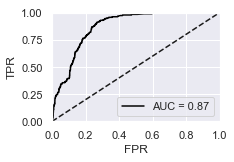

length of current GBS subset: 183


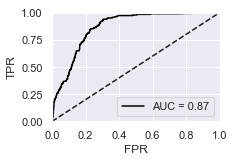

length of current GBS subset: 182


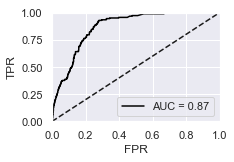

length of current GBS subset: 181


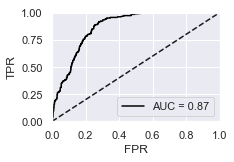

length of current GBS subset: 180


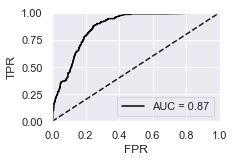

length of current GBS subset: 179


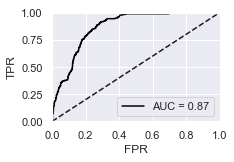

length of current GBS subset: 178


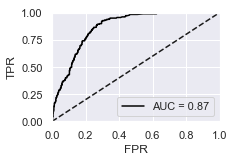

length of current GBS subset: 177


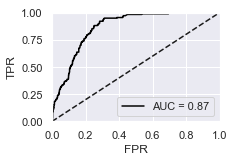

length of current GBS subset: 176


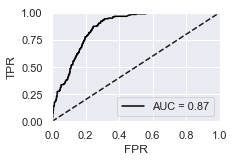

length of current GBS subset: 175


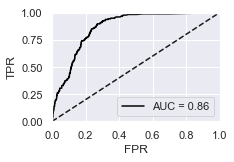

length of current GBS subset: 174


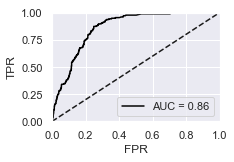

length of current GBS subset: 173


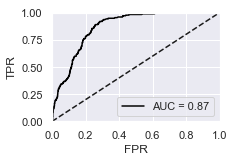

length of current GBS subset: 172


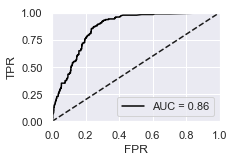

length of current GBS subset: 171


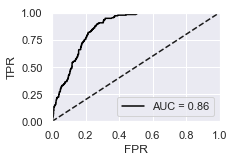

length of current GBS subset: 170


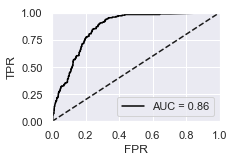

length of current GBS subset: 169


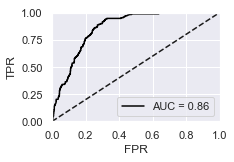

length of current GBS subset: 168


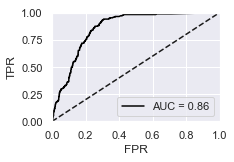

length of current GBS subset: 167


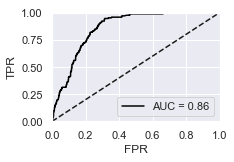

length of current GBS subset: 166


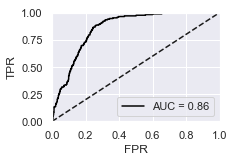

length of current GBS subset: 165


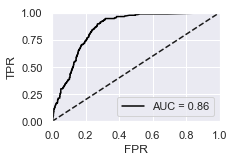

length of current GBS subset: 164


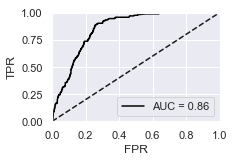

length of current GBS subset: 163


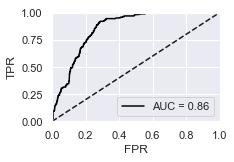

length of current GBS subset: 162


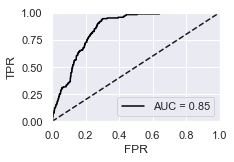

length of current GBS subset: 161


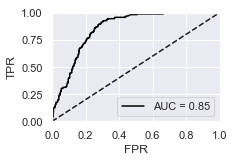

length of current GBS subset: 160


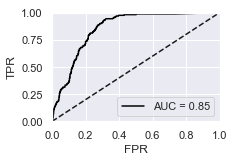

length of current GBS subset: 159


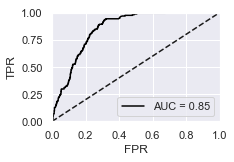

length of current GBS subset: 158


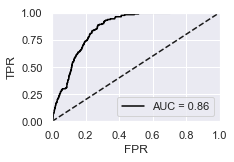

length of current GBS subset: 157


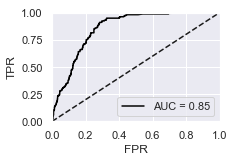

length of current GBS subset: 156


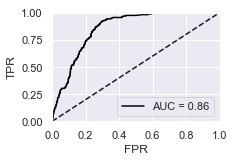

length of current GBS subset: 155


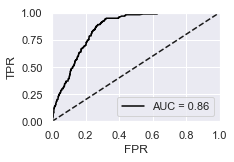

length of current GBS subset: 154


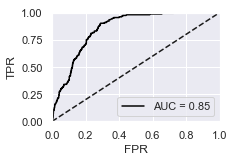

length of current GBS subset: 153


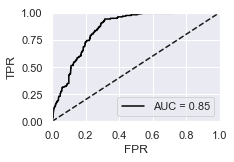

length of current GBS subset: 152


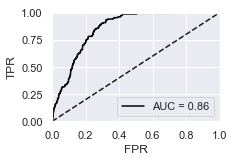

length of current GBS subset: 151


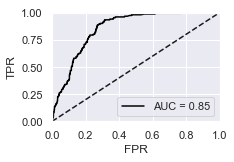

length of current GBS subset: 150


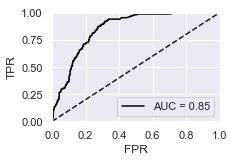

length of current GBS subset: 149


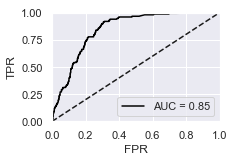

length of current GBS subset: 148


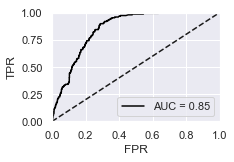

length of current GBS subset: 147


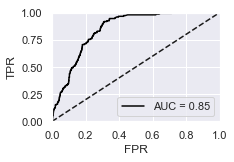

length of current GBS subset: 146


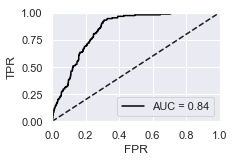

length of current GBS subset: 145


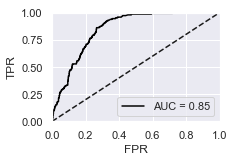

length of current GBS subset: 144


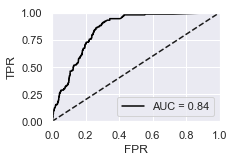

length of current GBS subset: 143


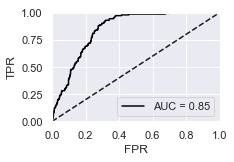

length of current GBS subset: 142


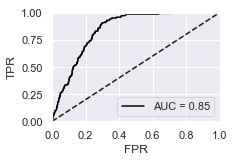

length of current GBS subset: 141


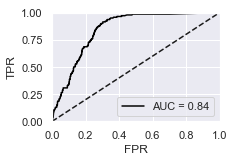

length of current GBS subset: 140


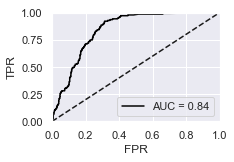

length of current GBS subset: 139


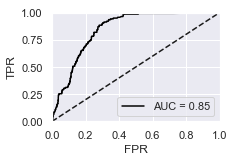

length of current GBS subset: 138


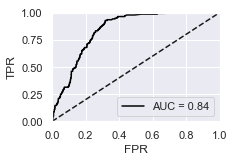

length of current GBS subset: 137


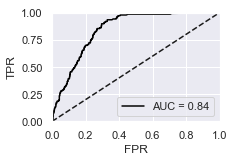

length of current GBS subset: 136


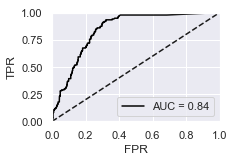

length of current GBS subset: 135


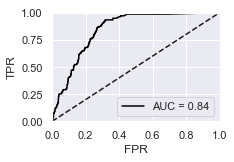

length of current GBS subset: 134


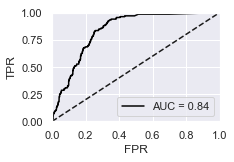

length of current GBS subset: 133


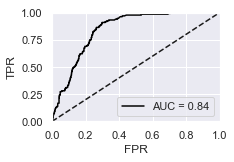

length of current GBS subset: 132


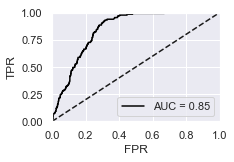

length of current GBS subset: 131


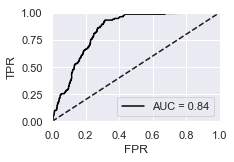

length of current GBS subset: 130


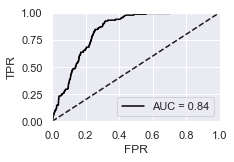

length of current GBS subset: 129


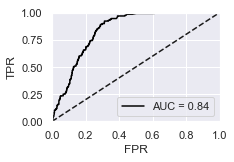

length of current GBS subset: 128


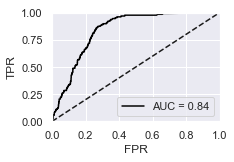

length of current GBS subset: 127


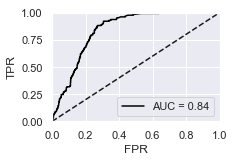

length of current GBS subset: 126


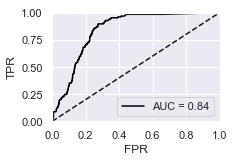

length of current GBS subset: 125


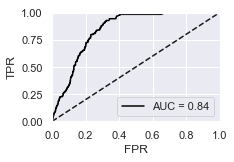

length of current GBS subset: 124


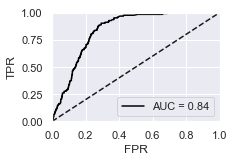

length of current GBS subset: 123


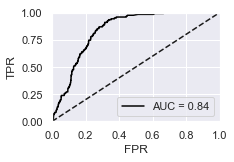

length of current GBS subset: 122


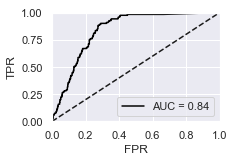

length of current GBS subset: 121


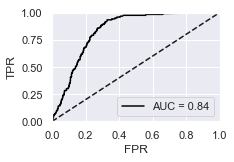

length of current GBS subset: 120


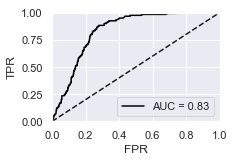

length of current GBS subset: 119


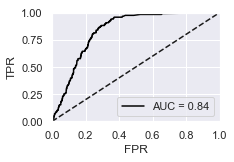

length of current GBS subset: 118


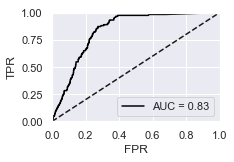

length of current GBS subset: 117


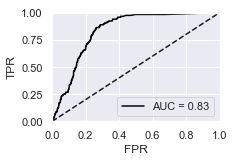

length of current GBS subset: 116


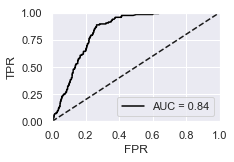

length of current GBS subset: 115


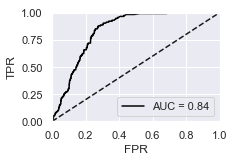

length of current GBS subset: 114


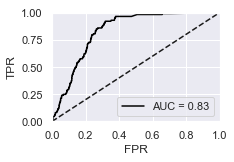

length of current GBS subset: 113


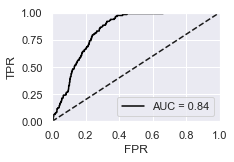

length of current GBS subset: 112


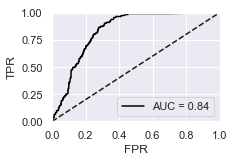

length of current GBS subset: 111


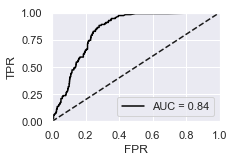

length of current GBS subset: 110


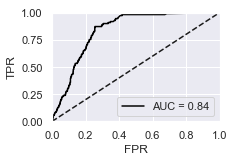

length of current GBS subset: 109


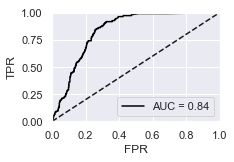

length of current GBS subset: 108


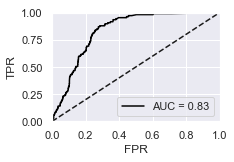

length of current GBS subset: 107


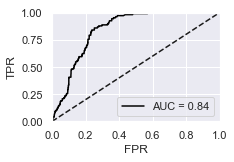

length of current GBS subset: 106


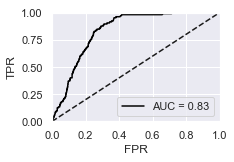

length of current GBS subset: 105


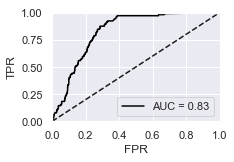

length of current GBS subset: 104


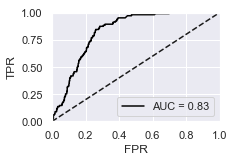

length of current GBS subset: 103


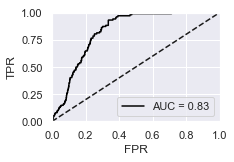

length of current GBS subset: 102


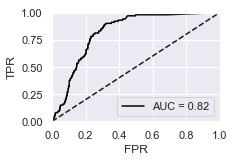

length of current GBS subset: 101


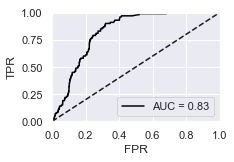

length of current GBS subset: 100


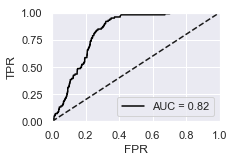

length of current GBS subset: 99


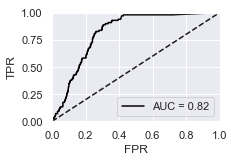

length of current GBS subset: 98


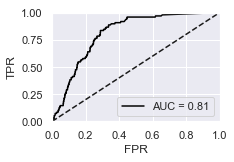

length of current GBS subset: 97


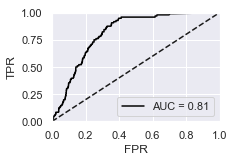

length of current GBS subset: 96


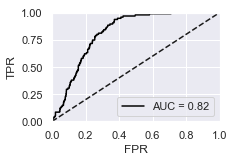

length of current GBS subset: 95


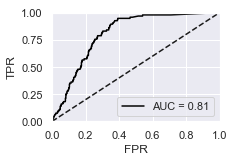

length of current GBS subset: 94


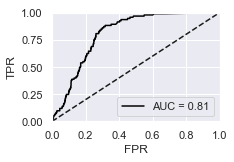

length of current GBS subset: 93


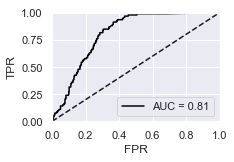

length of current GBS subset: 92


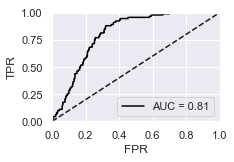

length of current GBS subset: 91


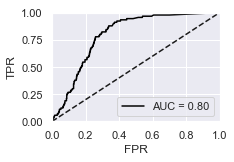

length of current GBS subset: 90


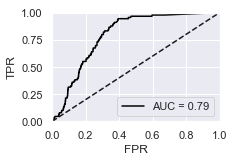

length of current GBS subset: 89


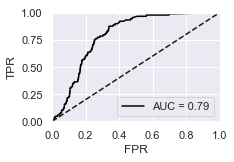

length of current GBS subset: 88


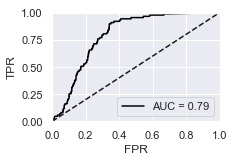

length of current GBS subset: 87


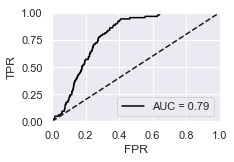

length of current GBS subset: 86


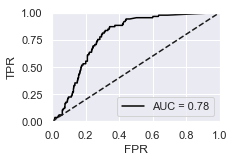

length of current GBS subset: 85


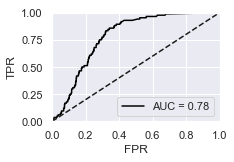

length of current GBS subset: 84


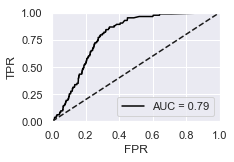

length of current GBS subset: 83


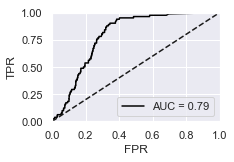

length of current GBS subset: 82


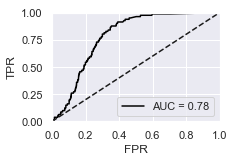

length of current GBS subset: 81


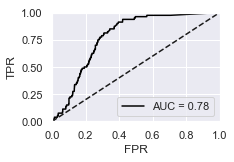

length of current GBS subset: 80


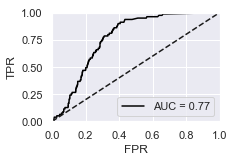

length of current GBS subset: 79


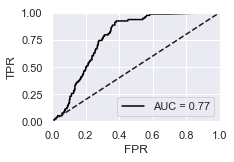

length of current GBS subset: 78


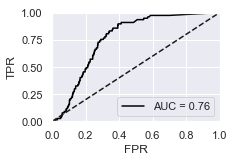

length of current GBS subset: 77


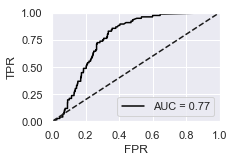

length of current GBS subset: 76


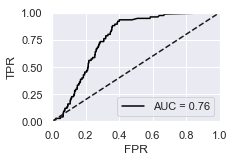

length of current GBS subset: 75


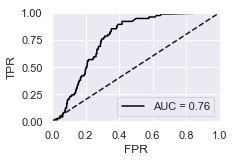

length of current GBS subset: 74


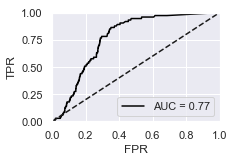

length of current GBS subset: 73


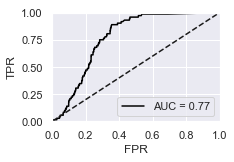

length of current GBS subset: 72


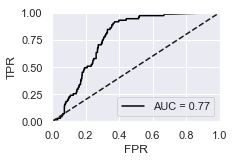

length of current GBS subset: 71


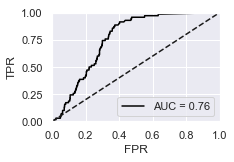

length of current GBS subset: 70


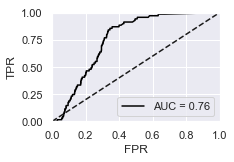

length of current GBS subset: 69


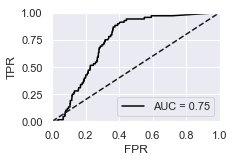

length of current GBS subset: 68


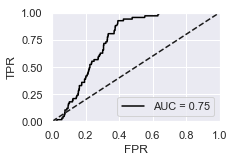

length of current GBS subset: 67


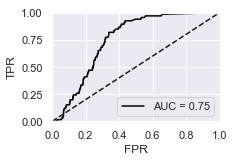

length of current GBS subset: 66


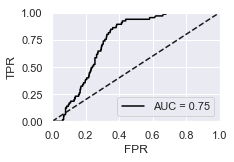

length of current GBS subset: 65


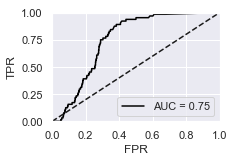

length of current GBS subset: 64


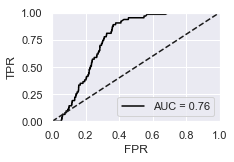

length of current GBS subset: 63


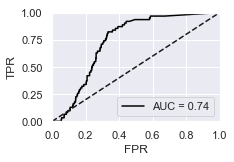

length of current GBS subset: 62


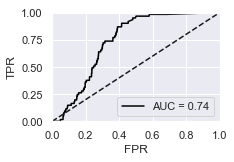

length of current GBS subset: 61


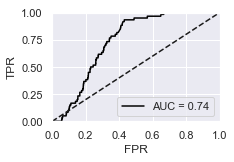

length of current GBS subset: 60


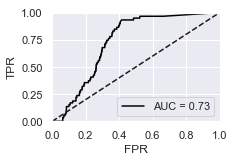

length of current GBS subset: 59


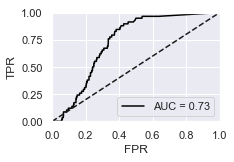

length of current GBS subset: 58


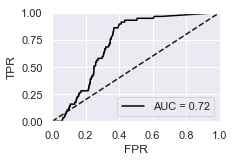

length of current GBS subset: 57


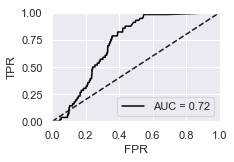

length of current GBS subset: 56


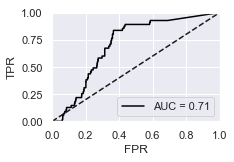

length of current GBS subset: 55


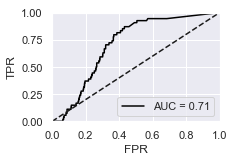

length of current GBS subset: 54


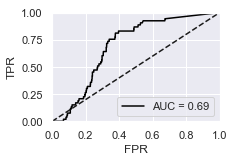

length of current GBS subset: 53


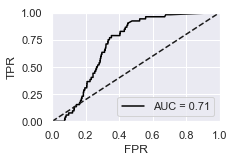

length of current GBS subset: 52


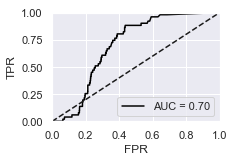

length of current GBS subset: 51


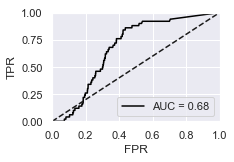

length of current GBS subset: 50


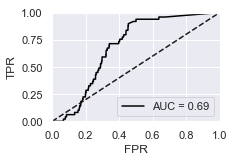

length of current GBS subset: 49


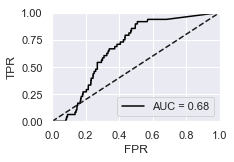

length of current GBS subset: 48


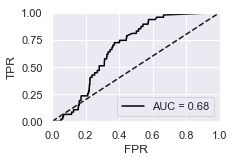

length of current GBS subset: 47


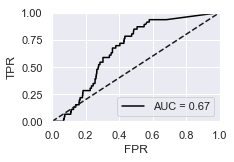

length of current GBS subset: 46


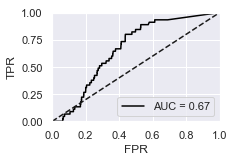

length of current GBS subset: 45


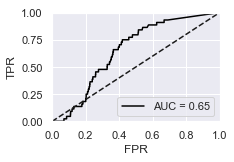

length of current GBS subset: 44


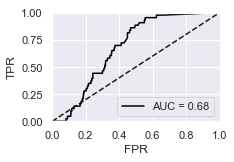

length of current GBS subset: 43


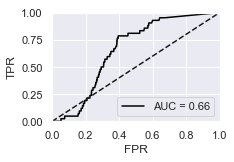

length of current GBS subset: 42


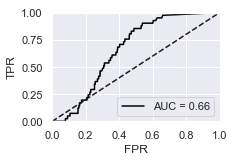

length of current GBS subset: 41


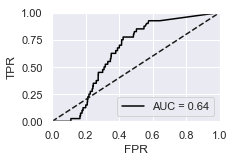

length of current GBS subset: 40


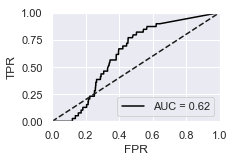

length of current GBS subset: 39


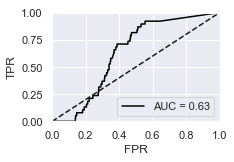

length of current GBS subset: 38


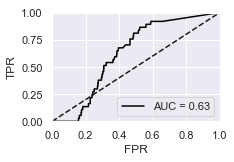

length of current GBS subset: 37


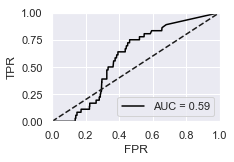

length of current GBS subset: 36


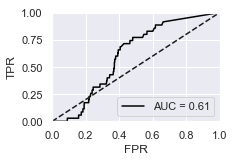

length of current GBS subset: 35


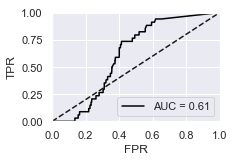

length of current GBS subset: 34


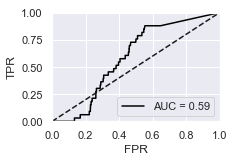

length of current GBS subset: 33


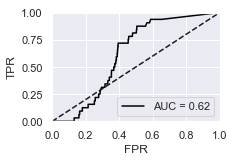

length of current GBS subset: 32


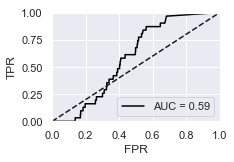

length of current GBS subset: 31


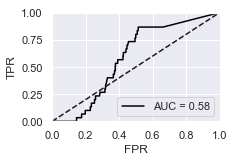

length of current GBS subset: 30


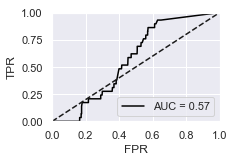

length of current GBS subset: 29


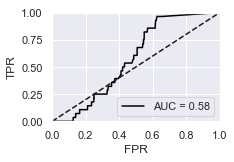

length of current GBS subset: 28


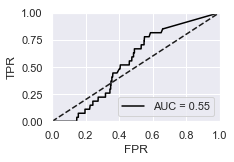

length of current GBS subset: 27


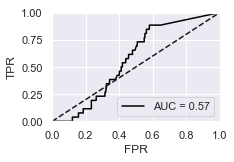

length of current GBS subset: 26


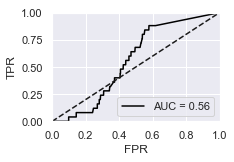

length of current GBS subset: 25


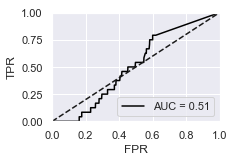

length of current GBS subset: 24


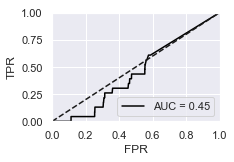

length of current GBS subset: 23


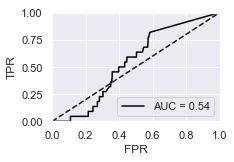

length of current GBS subset: 22


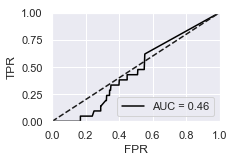

length of current GBS subset: 21


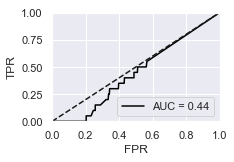

length of current GBS subset: 20


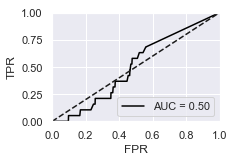

length of current GBS subset: 19


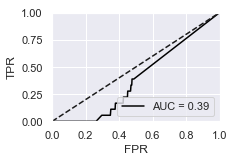

length of current GBS subset: 18


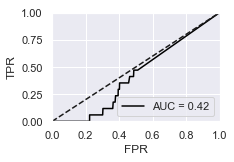

length of current GBS subset: 17


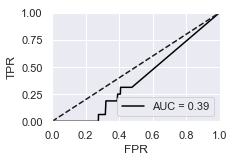

length of current GBS subset: 16


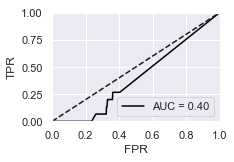

length of current GBS subset: 15


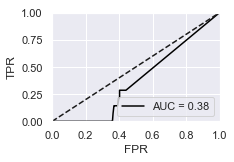

length of current GBS subset: 14


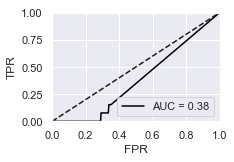

length of current GBS subset: 13


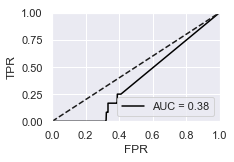

length of current GBS subset: 12


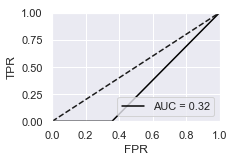

length of current GBS subset: 11


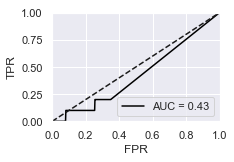

length of current GBS subset: 10


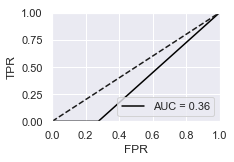

length of current GBS subset: 9


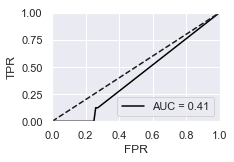

length of current GBS subset: 8


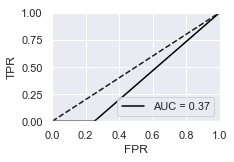

length of current GBS subset: 7


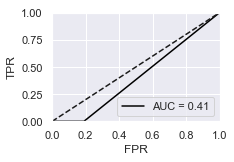

length of current GBS subset: 6


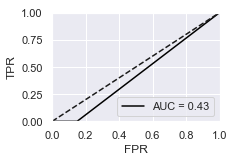

length of current GBS subset: 5


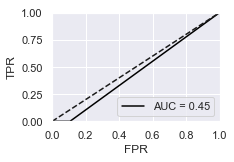

length of current GBS subset: 4


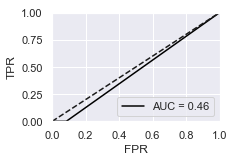

length of current GBS subset: 3


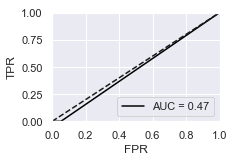

length of current GBS subset: 2


c:\users\laksa\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
c:\users\laksa\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


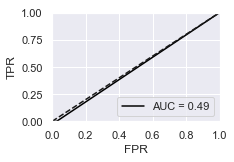

length of current GBS subset: 1


In [20]:
temperature = 1 
max_drop = 1

ks = []
auc = []
subset = []


while (len(data[data.label == 'nonrep']) > max_drop):

    rf = RandomForestClassifier(n_estimators=250, 
                                bootstrap=True,
                                max_depth=10,
                                oob_score=True,
                                n_jobs=-1)
    
    probs = cross_val_predict(rf,
                              data.drop(['label', 'probs'], axis=1),
                              data['label'], 
                              cv=3,
                              method='predict_proba')
    
    preds = cross_val_predict(rf,
                              data.drop(['label', 'probs'], axis=1),
                              data['label'], 
                              cv=3)
    
    if preds[0] == 'nonrep' and round(probs[0][0], 0) == 1:
        data['probs'] = [p[1] for p in probs]
    else:
        data['probs'] = [p[0] for p in probs]
    
    drop_id = []
    for _ in range(max_drop):
        softmax = sample(data[data.label == 'nonrep']['probs'], temperature)
        drop = data[data.label == 'nonrep'].iloc[[np.argmax(softmax)]].index[0]
        drop_id.append(drop)
        
    data.drop(data.index[drop_id], inplace=True)
    data.reset_index(drop=True, inplace=True)

    # EVALUATION
    subset.append(len(data[data.label == 'nonrep']))
    auc.append(roc([1 if k == 'nonrep' else 0 for k in data.label], data.probs, 1, 'name'))    
    ks.append(stats.ks_2samp(data[data.label == 'nonrep']['probs'], 
                             data[data.label == 'rep']['probs']))

    print('length of current GBS subset:', len(data[data.label == 'nonrep'].label))

In [21]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

subset = [i for i in range(1, 504)]

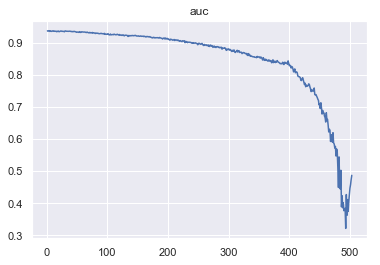

In [22]:
ax = sns.lineplot(x=subset, y=auc)
plt.title('auc')
plt.show()

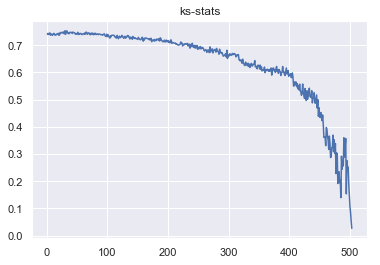

In [23]:
ax = sns.lineplot(x=subset, y=[a[0] for a in ks])
plt.title('ks-stats')
plt.show()

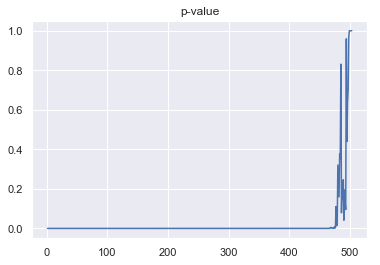

In [24]:
ax = sns.lineplot(x=subset, y=[a[1] for a in ks])
plt.title('p-value')
plt.show()